## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

(Note: for the first two steps don't forget to normalize your features and randomize a selection for training and testing.)


In [1]:
import numpy as np
from numpy.random import shuffle
import cv2
import glob
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
%matplotlib inline

### Example Car and Not Car Images

Cars: 8801 NonCars: 9021


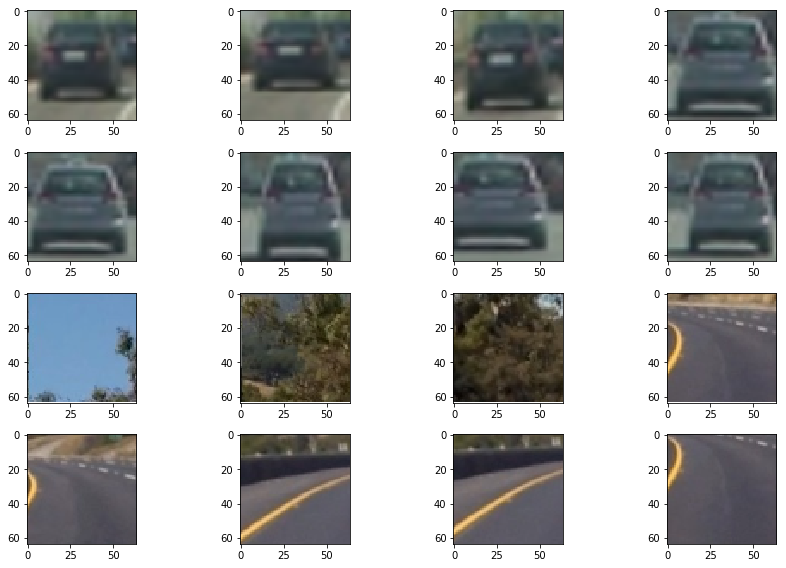

In [2]:
cars = [i for i in glob.glob('training/vehicles/*/*.png')]
notcars = [i for i in glob.glob('training/non-vehicles/*/*.png')]

print('Cars:', len(cars), 'NonCars:', len(notcars))

examples = [mpimg.imread(img) for img in np.concatenate([cars[0:8], notcars[0:8]])]
fig, axes = plt.subplots(4, 4, figsize=(12, 8))
axes = axes.ravel()
plt.tight_layout()

for i, img in enumerate(examples):
    axes[i].imshow(img)

### Feature Functions

In [3]:
# Returns one long vector of a resized image
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# Returns vector of histograms per image channel
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    return np.concatenate((channel1[0], channel2[0], channel3[0]))

# Returns HOG features for image
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Visualize Features

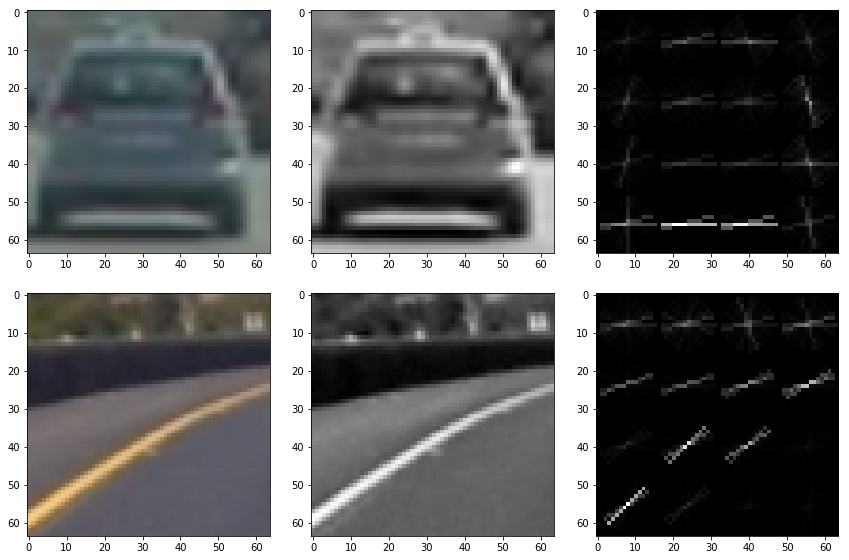

In [4]:
channel = 0
img_car = cv2.cvtColor(examples[4], cv2.COLOR_RGB2YUV)
features, hog_img_car = get_hog_features(img_car[:,:,channel], 16, 16, 2, vis=True)

img_not_car = cv2.cvtColor(examples[13], cv2.COLOR_RGB2YUV)
features, hog_img_not_car = get_hog_features(img_not_car[:,:,channel], 16, 16, 2, vis=True)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()
plt.tight_layout()

axes[0].imshow(examples[4])
axes[1].imshow(img_car[:,:,channel], cmap='gray')
axes[2].imshow(hog_img_car, cmap='gray')
axes[3].imshow(examples[13])
axes[4].imshow(img_not_car[:,:,channel], cmap='gray')
axes[5].imshow(hog_img_not_car, cmap='gray')

shuffle(cars)
shuffle(notcars)

### Supporting Functions

In [5]:
# Returns list of feature vectors per image
def get_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), orient=9, pix_per_cell=8, cell_per_block=2):
    features = []
    
    for file in imgs:
        img = mpimg.imread(file)
        # Optionally change color spaces
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)      
        # Get the downsampled color features
        #spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Get the histograms for each channel
        #hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Get HOG for all channels
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, feature_vec=True))
        hog_features = np.ravel(hog_features)   
        # Combine them all
        #features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        features.append(hog_features)

    return features

In [6]:
#cars = cars[0:500]
#notcars = notcars[0:500]

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2

t = time.time()
car_features = get_features(cars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
notcar_features = get_features(notcars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

#X_scaler = StandardScaler().fit(X_train)
# Scaling to be robust to outliers
X_scaler = RobustScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient,'orientations', pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = SVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

50.6 Seconds to extract features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188
40.02 Seconds to train SVC...
Train Accuracy of SVC =  0.9994
Test Accuracy of SVC =  0.995
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  0.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  0.  1.  0.  1.]
0.02893 Seconds to predict 10 labels with SVC


In [7]:
# Based on code from class

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, hist_bins, spatial_size):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            ## Ignore spaital and histogram
            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))   
            
            test_features = X_scaler.transform(hog_features.reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return windows

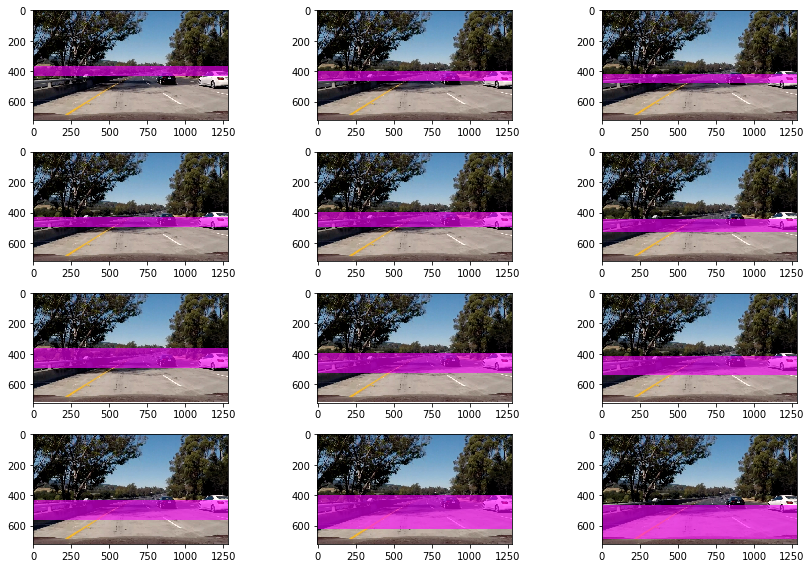

In [8]:
image = mpimg.imread('test_images/test5.jpg')
static_params = [svc, X_scaler, orient, pix_per_cell, cell_per_block, 32, (32,32)]
search_areas = [
    [368,432,1],
    [400,464,1],
    [416,480,1],
    [432,496,1],
    [400,496,1.5],
    [448,528,1.5],
    [368,496,2],
    [400,528,2],
    [416,544,2],
    [432,560,2],
    [400,624,3.5],
    [464,688,3.5],
]

fig, axes = plt.subplots(4, 3, figsize=(12, 8))
axes = axes.ravel()
plt.tight_layout()

for i, area in enumerate(search_areas):
    overlay = image.copy()
    output = image.copy()
    color = (255, 0, 255)
    cv2.rectangle(output, (0, area[0]), (image.shape[1], area[1]), color, cv2.FILLED)
    cv2.addWeighted(overlay, 0.4, output, 1 - 0.4, 0, output)
    axes[i].imshow(output)

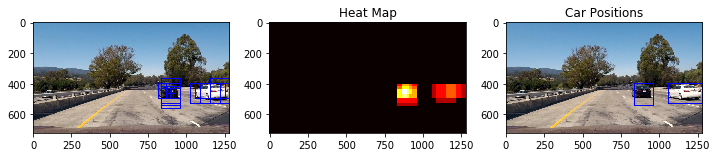

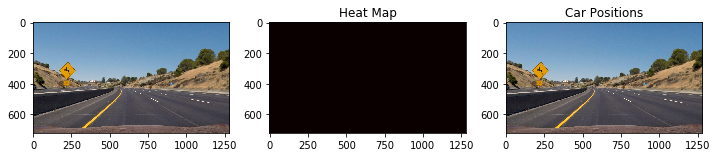

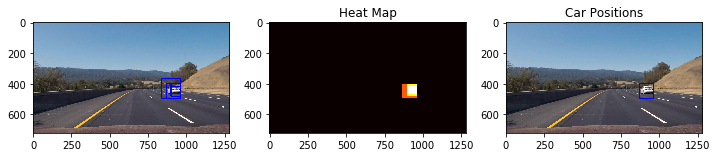

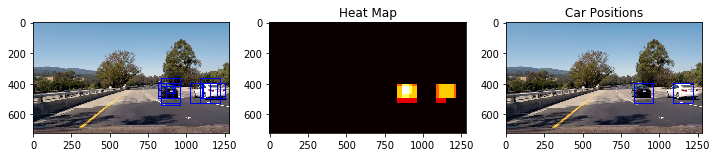

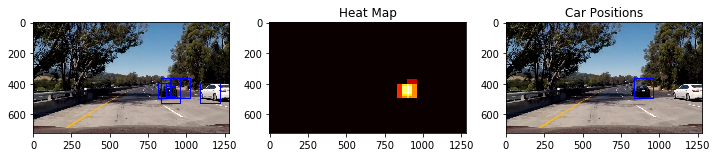

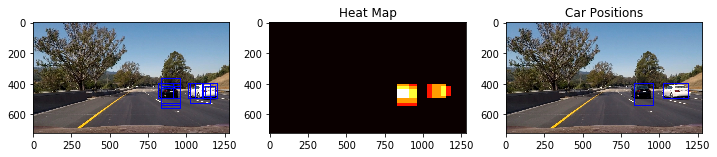

In [9]:
for file in glob.glob('test_images/*.jpg'):
    img = mpimg.imread(file)
    windows = []

    for area in search_areas:
        windows.extend(find_cars(img, *area, *static_params))
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    from scipy.ndimage.measurements import label
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    fig = plt.figure(figsize=(10,10))
    plt.subplot(131)
    plt.imshow(draw_boxes(img, windows))
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(133)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    fig.tight_layout()

In [10]:
prev_windows = []
def Boxes(img):
    global prev_windows
    
    win = []
    for area in search_areas:
        win.extend(find_cars(img, *area, *static_params))
    prev_windows.append(win)
    
    if len(prev_windows) > 15:
        del prev_windows[0]
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    for windows in prev_windows:
        heat = add_heat(heat, windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    from scipy.ndimage.measurements import label
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

clip = VideoFileClip("test_video.mp4").fl_image(Boxes)
#%time clip.write_videofile('test_video_output.mp4', audio=False)
clip.ipython_display()

 97%|█████████▋| 38/39 [00:48<00:01,  1.29s/it]
